## Import Libraries

**Intall Dependencies with pip**
    

install dependencies with pip
requirements.txt -r
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
import LSTMpy as lstm

## import tabulate for latex table
from tabulate import tabulate

# Set seed for reproducability
np.random.seed(42)
torch.manual_seed(42)

% matplotlib inline
% load_ext autoreload

UsageError: Line magic function `%` not found.


## Get Data

In [2]:
## Get the data for the respective variable to model

columns_list = ["SEKDKK, SEKUSD, SEKNOK, SEKGBP, SEKCNY, SEKJPY"]

column = "SEKDKK"

data = lstm.read_data(column, True)

            SEKDKK
Date              
2020-06-30  0.7111
2020-07-01  0.7125
2020-07-02  0.7127
2020-07-03  0.7118
2020-07-06  0.7088
...            ...
2023-04-20  0.6572
2023-04-21  0.6578
2023-04-24  0.6578
2023-04-25  0.6592
2023-04-26  0.6573

[716 rows x 1 columns]
(716, 1)
0


/Users/vg/Desktop/Model – BA/LSTMpy.py:19: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Date"] = pd.to_datetime(data["Date"])


## Sliding Window & Preprocessing

In [3]:
seq_length = 4
train_ratio = 0.8
val_ratio = 0.1581

trainX, trainY, valX, valY, testX, testY, sc, train_size, val_size, test_size, y, data_normalized = lstm.preprocessing(data, seq_length, train_ratio, val_ratio)

## Define LSTM Model

In [4]:
# LSTM model definition

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        ## Define the parameters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    # Define the forward pass
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        return out

## Define Model Training Parameters

In [5]:

np.random.seed(42)
torch.manual_seed(42)

# Model training
num_epochs = 5550
learning_rate = 0.09

input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []


for epoch in (range(num_epochs)):
    # Training
    lstm.train()
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    # Validation
    lstm.eval()
    val_outputs = lstm(valX)
    val_loss = criterion(val_outputs, valY)

    # Save losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print("Epoch: %d, Training Loss: %1.5f, Validation Loss: %1.5f" % (epoch, loss.item(), val_loss.item()))

       


Epoch: 0, Training Loss: 0.17006, Validation Loss: 0.10040
Epoch: 100, Training Loss: 0.00100, Validation Loss: 0.02004
Epoch: 200, Training Loss: 0.00071, Validation Loss: 0.01277
Epoch: 300, Training Loss: 0.00064, Validation Loss: 0.00755
Epoch: 400, Training Loss: 0.00064, Validation Loss: 0.00603
Epoch: 500, Training Loss: 0.00063, Validation Loss: 0.00511
Epoch: 600, Training Loss: 0.00063, Validation Loss: 0.00492
Epoch: 700, Training Loss: 0.00063, Validation Loss: 0.00446
Epoch: 800, Training Loss: 0.00064, Validation Loss: 0.00435
Epoch: 900, Training Loss: 0.00062, Validation Loss: 0.00410
Epoch: 1000, Training Loss: 0.00077, Validation Loss: 0.00377
Epoch: 1100, Training Loss: 0.00062, Validation Loss: 0.00391
Epoch: 1200, Training Loss: 0.00062, Validation Loss: 0.00376
Epoch: 1300, Training Loss: 0.00067, Validation Loss: 0.00426
Epoch: 1400, Training Loss: 0.00062, Validation Loss: 0.00367
Epoch: 1500, Training Loss: 0.00062, Validation Loss: 0.00353
Epoch: 1600, Trainin

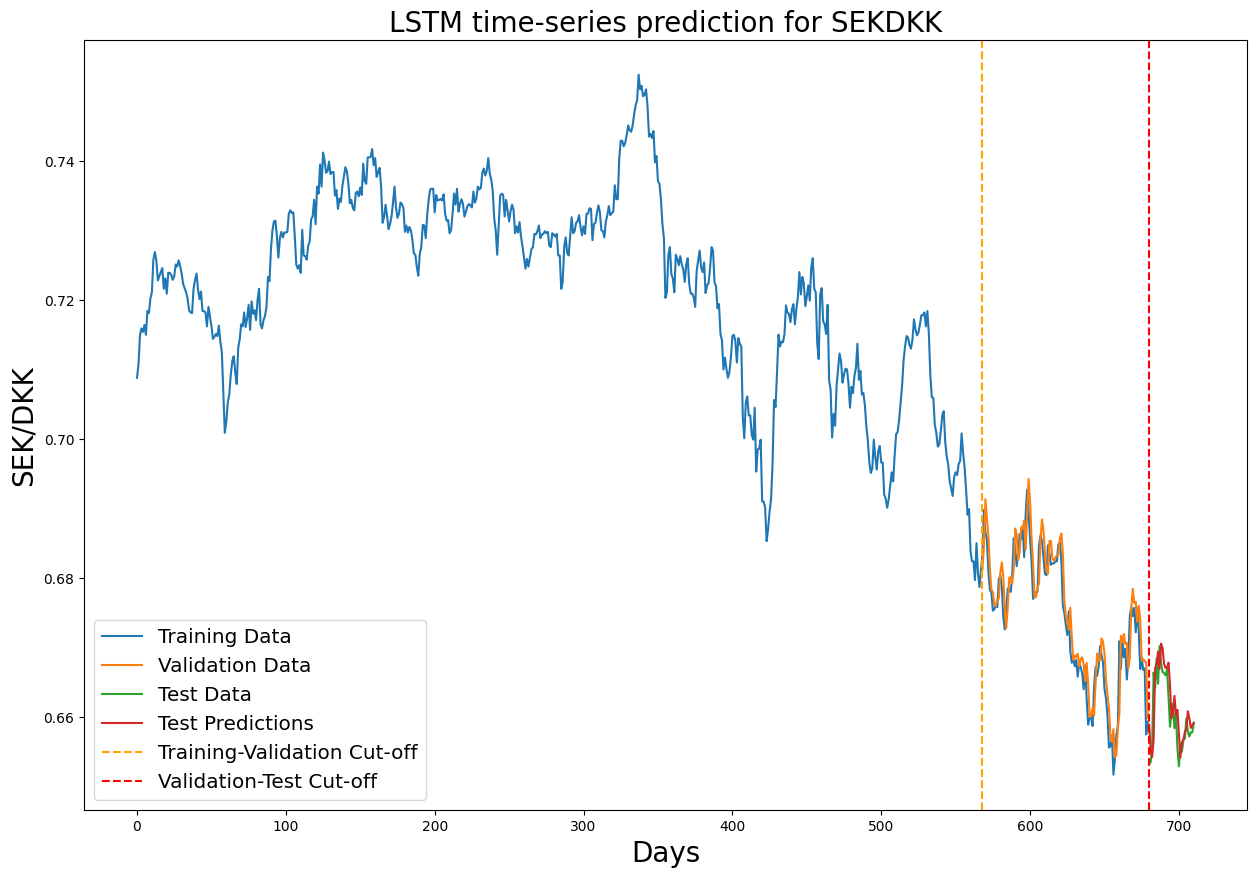

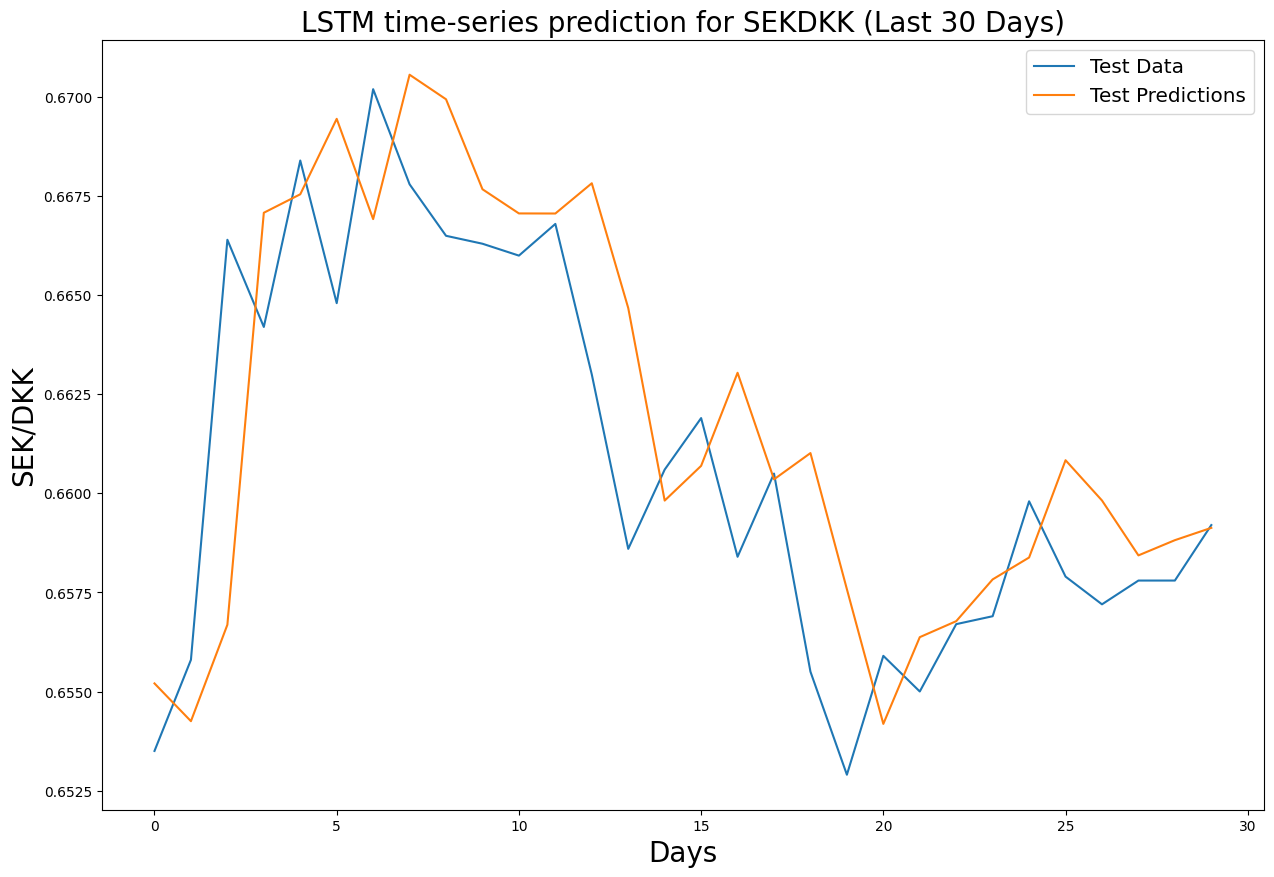

In [6]:
# Model evaluation
lstm.eval()
train_predict = lstm(torch.cat((trainX, valX)))
test_predict = lstm(testX)

train_predict = sc.inverse_transform(train_predict.data.numpy())
trainY_plot = sc.inverse_transform(torch.cat((trainY, valY)).data.numpy())
test_predict = sc.inverse_transform(test_predict.data.numpy())
testY_plot = sc.inverse_transform(testY.data.numpy())

# Plotting
plt.figure(figsize=(15, 10))
plt.plot(trainY_plot, label="Training Data")
plt.plot(range(train_size, train_size + val_size), train_predict[train_size:], label="Validation Data")
plt.plot(range(train_size + val_size, train_size + val_size + len(testY_plot)), testY_plot, label="Test Data")
plt.plot(range(train_size + val_size, train_size + val_size + len(test_predict)), test_predict, label="Test Predictions")
plt.axvline(x=train_size, c="orange", linestyle="--", label="Training-Validation Cut-off")
plt.axvline(x=train_size + val_size, c="r", linestyle="--", label="Validation-Test Cut-off")
plt.legend(loc="best", fontsize="x-large")
plt.title(f"LSTM time-series prediction for {column}", size=20)
plt.xlabel("Days", size=20)
plt.ylabel("SEK/DKK", size=20)
## save the plot as a png file
plt.savefig(f'LSTM prediction for {column}')
plt.show()

# Plot the last 30 values for the test set
plt.figure(figsize=(15, 10))
plt.plot(testY_plot[-30:], label="Test Data")
plt.plot(test_predict[-30:], label="Test Predictions")
plt.legend(loc="best", fontsize="x-large")
plt.title(f"LSTM time-series prediction for {column} (Last 30 Days)" , size=20)
plt.xlabel("Days", size=20)
plt.ylabel("SEK/DKK", size=20)
## save the plot as a png file
#plt.savefig(f'LSTM prediction for {column}')
plt.show()


In [7]:
# Evaluation metrics

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


print("Test MSE:", mean_squared_error(testY_plot, test_predict))
print("Test R^2:", r2_score(testY_plot, test_predict))
print("Test MAE:", mean_absolute_error(testY_plot, test_predict))
print("Test Median AE:", median_absolute_error(testY_plot, test_predict))
print("Test MAPE:", mean_absolute_percentage_error(testY_plot, test_predict))


## output the metrics in a latex table using tabulate
table = [["R^2", r2_score(testY_plot, test_predict)], 
            ["MSE", mean_squared_error(testY_plot, test_predict)],
            ["MAE", mean_absolute_error(testY_plot, test_predict)],
            ["MAPE", mean_absolute_percentage_error(testY_plot, test_predict)],
            ["RMSE", root_mean_squared_error(testY_plot, test_predict)]]

print(tabulate(table, tablefmt="latex"))

## save the table as a latex file
with open(f"LSTM metrics for {column}.tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex"))



Test MSE: 1.1524286e-05
Test R^2: 0.5255354415913436
Test MAE: 0.0025784085
Test Median AE: 0.0017040968
Test MAPE: 0.0039032048
\begin{tabular}{lr}
\hline
 R\^{}2  & 0.525535    \\
 MSE  & 1.15243e-05 \\
 MAE  & 0.00257841  \\
 MAPE & 0.0039032   \\
 RMSE & 0.00339474  \\
\hline
\end{tabular}


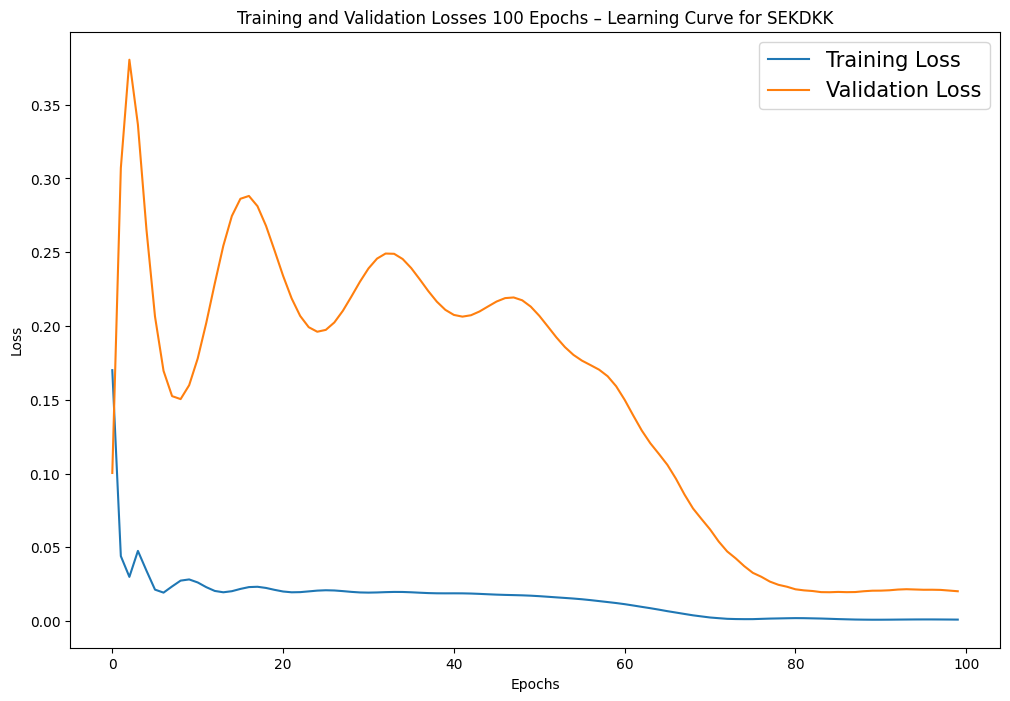

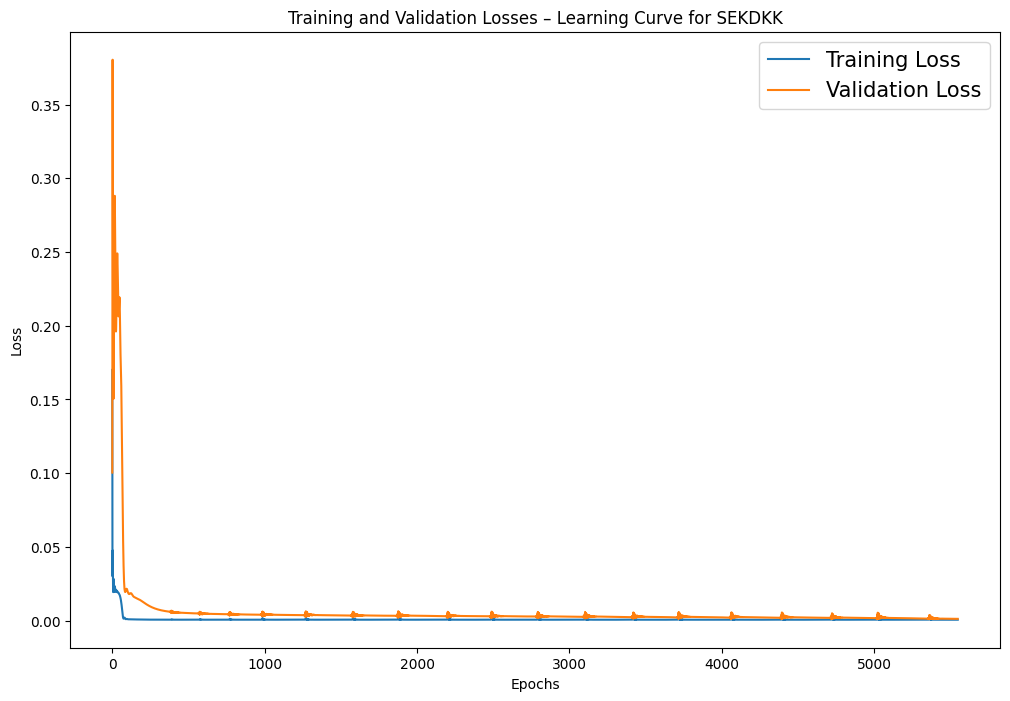

In [8]:
#Plot the loss and validation loss on the y-axis and the number of epochs on the x-axis
#PLot only for the first 100
plt.figure(figsize=(12, 8))
plt.plot(train_losses[:100], label="Training Loss")
plt.plot(val_losses[:100], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training and Validation Losses 100 Epochs – Learning Curve for {column}")
plt.legend(loc="best", fontsize = 15)
plt.savefig(f'LSTM learning curve (100 Epochs) for {column}')
plt.show()



plt.figure(figsize=(12, 8))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training and Validation Losses – Learning Curve for {column}")
plt.legend(loc="best", fontsize = 15)
plt.savefig(f'LSTM learning curve for {column}')
plt.show()



In [9]:
## Define counter for the number of times the model predicts the correct direction of the exchange rate
counter = 0
counter_random = 0

correct_direction_random = 0
false_direction_random = 0

correct_direction = 0
false_direction = 0

## initiate random walk for comparison
# set seed
np.random.seed(42)

# create random walk
random_walk = np.cumsum(np.random.normal(0, 1, len(test_predict)))

# if random walk moves up or down in the same direction as the exchange rate, add 1 to the counter
for i in range(1, len(test_predict)):
    if random_walk[i] > random_walk[i-1] and testY_plot[i] > testY_plot[i-1]:
        counter_random += 1
        correct_direction_random += 1
    elif random_walk[i] < random_walk[i-1] and testY_plot[i] < testY_plot[i-1]:
        counter_random += 1
        correct_direction_random += 1
    else:
        counter_random -= 1
        false_direction_random += 1



## Loop through the test set and compare the predicted direction with the actual direction
for i in range(1, len(test_predict)):
    if test_predict[i] > test_predict[i-1] and testY_plot[i] > testY_plot[i-1]:
        counter += 1
        correct_direction += 1
    elif test_predict[i] < test_predict[i-1] and testY_plot[i] < testY_plot[i-1]:
        counter += 1
        correct_direction += 1
    else:
        counter -= 1
        false_direction += 1
    
## Calculate the accuracy of the model
print("Counter", counter)
print("Total number of predictions:", len(test_predict))
print("Number of correct directions:", correct_direction)
print("Number of false directions:", false_direction)
print("Percentage of correct directions:", correct_direction / len(test_predict))
print("Percentage of false directions:", false_direction / len(test_predict))

## output the metrics in a latex table using tabulate and a title 

table = [["Counter", counter],
            ["Total number of predictions", len(test_predict)],
            ["Number of correct directions", correct_direction],
            ["Number of false directions", false_direction],
            ["Percentage of correct directions", correct_direction / len(test_predict)],
            ["Percentage of false directions", false_direction / len(test_predict)]]


table_random = [["Counter", counter_random],
            ["Total number of predictions", len(test_predict)],
            ["Number of correct directions", correct_direction_random],
            ["Number of false directions", false_direction_random],
            ["Percentage of correct directions", correct_direction_random / len(test_predict)],
            ["Percentage of false directions", false_direction_random / len(test_predict)]]


## Table for both models

table_concat = [
            ["Total number of predictions", len(test_predict) - 1, len(test_predict) - 1],
            ["Number of correct directions", correct_direction, correct_direction_random],
            ["Number of false directions", false_direction, false_direction_random],
            ["Percentage of correct directions", "{:.2%}".format(correct_direction / (len(test_predict) - 1)), "{:.2%}".format(correct_direction_random / (len(test_predict) - 1))],
            ["Percentage of false directions", "{:.2%}".format(false_direction / (len(test_predict)-1 )), "{:.2%}".format(false_direction_random / (len(test_predict)-1 ))]]

print(tabulate(table_concat, tablefmt="latex", headers=[f"LSTM {column}", "Random walk"]))



Counter -4
Total number of predictions: 31
Number of correct directions: 13
Number of false directions: 17
Percentage of correct directions: 0.41935483870967744
Percentage of false directions: 0.5483870967741935
\begin{tabular}{lll}
\hline
                                  & LSTM SEKDKK   & Random walk   \\
\hline
 Total number of predictions      & 30            & 30            \\
 Number of correct directions     & 13            & 13            \\
 Number of false directions       & 17            & 17            \\
 Percentage of correct directions & 43.33\%        & 43.33\%        \\
 Percentage of false directions   & 56.67\%        & 56.67\%        \\
\hline
\end{tabular}


<Figure size 2000x1000 with 0 Axes>

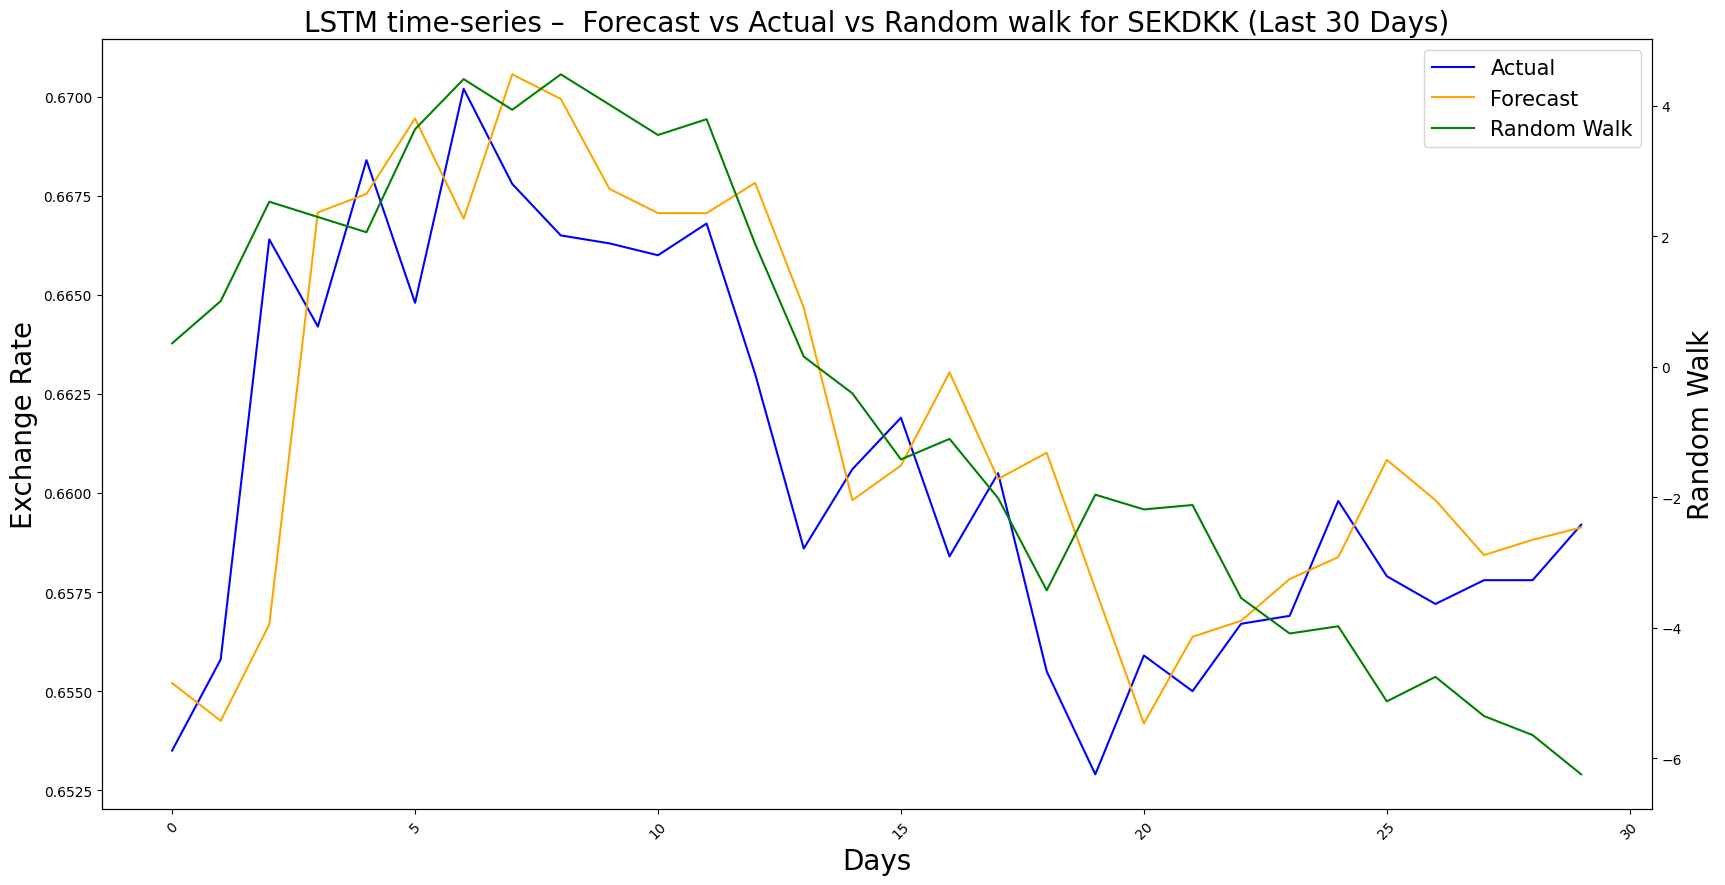

In [10]:
# Plot the last 30 values for the test set with random walk on second y axis
plt.figure(figsize=(20, 10))

# define two y axes
fig, ax1 = plt.subplots()

# make subplot bigger
fig.set_size_inches(20, 10)


# plot test data and predictions on first y axis
ax1.plot(testY_plot[-30:], label="Actual", color="blue")
ax1.plot(test_predict[-30:], label="Forecast", color="orange")

plt.xlabel("Days", size = 20)
plt.xticks(rotation = 45)
plt.ylabel("Exchange Rate", size = 20)
plt.title(f"LSTM time-series –  Forecast vs Actual vs Random walk for {column} (Last 30 Days)" , size = 20)

# plot random walk on second y axis
ax2 = ax1.twinx()
ax2.plot(random_walk[-30:], label="Random Walk", color="green")
plt.ylabel("Random Walk", size = 20)

## make x axis use dates instead of numbers
# import mdates

## make legend for both y axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='best', fontsize = 15)

## save figure
plt.savefig(f'LSTM time-series for{column} (Last 30 Days)')

plt.show()

Jarque-Bera test for normality of the residuals: 
 
 SignificanceResult(statistic=13.921929392433086, pvalue=0.000948181426157344)


/var/folders/zn/8wl2ftxd7sg0pjvzvx59s5xr0000gn/T/ipykernel_15649/644780286.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")


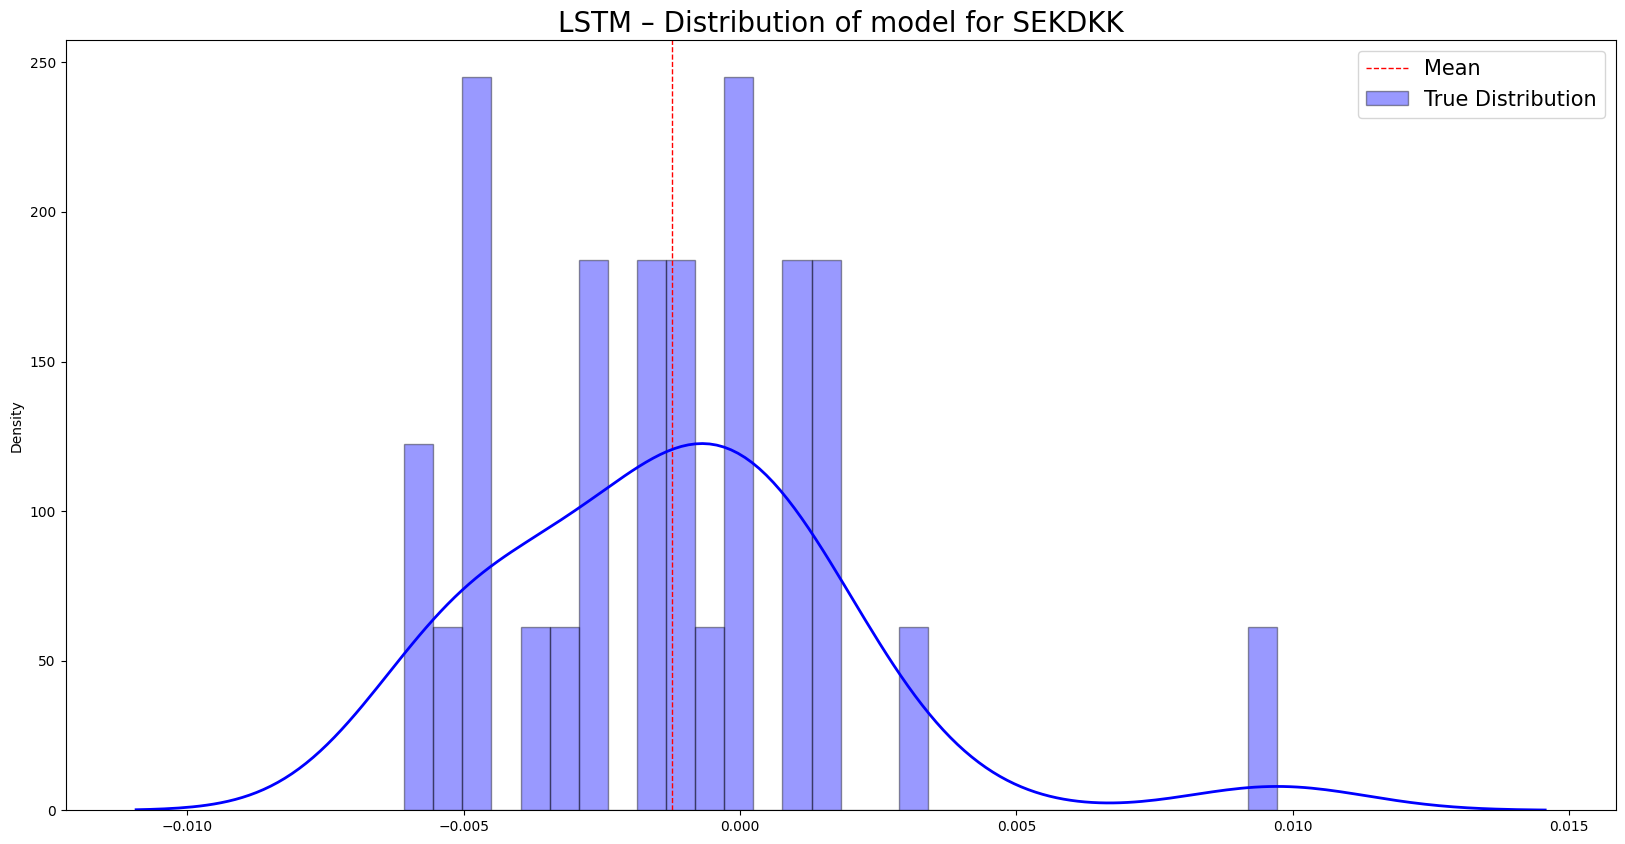

In [11]:
## Jarque-Bera test for normality of the residuals
from scipy import stats
import seaborn as sns

## define residuals for the whole model
residuals =  testY_plot - test_predict

jb_test = stats.jarque_bera(residuals)
print("Jarque-Bera test for normality of the residuals: \n \n", jb_test)


## Find mean of the residuals
mean = residuals.mean()
mean = float(mean)

# Plot distribution of data 
plt.figure(figsize=(20,10))
plt.title(f"LSTM – Distribution of model for {column}", size = 20)

## add a vertical line at the mean
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label = "Mean")

## add true bell curve to the plot
sns.distplot(residuals, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")

plt.legend(fontsize = 15)
plt.show()



In [12]:
## Import nessesary packages
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from tabulate import tabulate



## Plot summary of the model along with white noise test, ljung box test, heteroscedasticity and normality test in a latex tabel using tabulate

def summary_table(residuals):
    """Function to create a summary table for the model"""
    # define the summary table
    summary_table = [["Mean", mean],
                    ["Standard Error", np.std(residuals)],
                    ["Skewness", stats.skew(residuals)],
                    ["Kurtosis", stats.kurtosis(residuals)],
                    ["Jarque-Bera test", jb_test[0]],
                    ["p-value", jb_test[1]],
                    ["Ljung-Box test", statsmodels.stats.diagnostic.acorr_ljungbox(residuals, lags=[5], return_df=True).iloc[0,0]],
                    ["p-value", statsmodels.stats.diagnostic.acorr_ljungbox(residuals, lags=[5], return_df=True).iloc[0,1]],
                    ["Heteroscedasticity", statsmodels.stats.diagnostic.het_arch(residuals)[0]],
                    ["p-value", statsmodels.stats.diagnostic.het_arch(residuals)[1]],
                    ["Normality", stats.normaltest(residuals)[0]],
                    ["p-value", stats.normaltest(residuals)[1]]]
    return summary_table


summary_table = summary_table(residuals)

print(tabulate(summary_table, tablefmt="latex", headers=[f"Summary table for {column}", "Value"]))

\begin{tabular}{lr}
\hline
 Summary table for SEKDKK   &        Value \\
\hline
 Mean                       & -0.0012407   \\
 Standard Error             &  0.0031599   \\
 Skewness                   &  1.0638      \\
 Kurtosis                   &  2.50032     \\
 Jarque-Bera test           & 13.9219      \\
 p-value                    &  0.000948181 \\
 Ljung-Box test             &  2.92515     \\
 p-value                    &  0.711525    \\
 Heteroscedasticity         &  4.87025     \\
 p-value                    &  0.56056     \\
 Normality                  & 12.4786      \\
 p-value                    &  0.00195124  \\
\hline
\end{tabular}


/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
